In [1]:
import math
import numpy as np
import torch
from higherOrderKME import sigkernel

# Github example

In [ ]:
# Specify the static kernel (for linear kernel use sigkernel.LinearKernel())
static_kernel = sigkernel.RBFKernel(sigma=0.5)

# Specify dyadic order for PDE solver (int > 0, default 0, the higher the more accurate but slower)
dyadic_order = 2

# Specify the hyperparameter for the estimation of the conditional KME
lambda_ = 1e-5

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

# Synthetic data
n, len_x, len_y, dim = 100, 10, 20, 2
x = torch.rand((n,len_x,dim), dtype=torch.float64, device='cuda') # shape (batch,len_x,dim)
y = torch.rand((n,len_y,dim), dtype=torch.float64, device='cuda') # shape (batch,len_y,dim)

# Compute the (classical) first order MMD distance between samples x ~ P and samples y ~ Q, where P,Q are two distributions on path space
mmd_order1 = signature_kernel.compute_mmd(x, y, order=1)

# Compute the second order MMD distance between samples x ~ P and samples y ~ Q, where P,Q are two distributions on path space
mmd_order2 = signature_kernel.compute_mmd(x, y, lambda_=lambda_, order=2)

# Test whether only end points matter

In [45]:
seq_len = 5
x = np.arange(seq_len).reshape(1,seq_len,1)
y = np.arange(seq_len, 2*seq_len).reshape(1,seq_len,1)
x.shape, x.flatten(), y.shape, y.flatten()

((1, 5, 1), array([0, 1, 2, 3, 4]), (1, 5, 1), array([5, 6, 7, 8, 9]))

In [46]:
t = np.arange(seq_len).reshape(1, -1, 1)
x = np.concatenate([t, x], axis=-1)
y = np.concatenate([t, y], axis=-1)
x.shape, y.shape

((1, 5, 2), (1, 5, 2))

In [47]:
static_kernel = sigkernel.LinearKernel()
dyadic_order = 8
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

In [48]:
xt = torch.tensor(x, dtype=torch.float64)
yt = torch.tensor(y, dtype=torch.float64)
idx = np.full((seq_len), False)
idx[0] = True
idx[-1] = True
print(signature_kernel.compute_kernel(xt, xt), signature_kernel.compute_kernel(xt[:,idx,:], xt[:,idx,:]))
print(signature_kernel.compute_kernel(xt, yt), signature_kernel.compute_kernel(xt[:,idx,:], yt[:,idx,:]))

tensor([9831.7362], dtype=torch.float64) tensor([9834.4998], dtype=torch.float64)
tensor([9831.7362], dtype=torch.float64) tensor([9834.4998], dtype=torch.float64)


# Verify KME paper code with calculations using linear kernel

In [21]:
seq_len = 5
x = np.arange(seq_len).reshape((1, seq_len, 1))
x

array([[[0],
        [1],
        [2],
        [3],
        [4]]])

In [22]:
# Specify the static kernel (for linear kernel use sigkernel.LinearKernel())
static_kernel = sigkernel.LinearKernel()

# Specify dyadic order for PDE solver (int > 0, default 0, the higher the more accurate but slower)
dyadic_order = 10
n_levels = 16

# Initialize the corresponding signature kernel
kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

In [23]:
# calculate signature levels of 1D path
diff = (x[:,-1,:] - x[:,0,:]).squeeze()

x_levels = []
for i in range(n_levels+1):
    x_levels.append(diff**i / math.factorial(i))

x_levels

[1.0,
 4.0,
 8.0,
 10.666666666666666,
 10.666666666666666,
 8.533333333333333,
 5.688888888888889,
 3.250793650793651,
 1.6253968253968254,
 0.7223985890652558,
 0.28895943562610227,
 0.10507615840949175,
 0.03502538613649725,
 0.010777041888152998,
 0.003079154825186571,
 0.0008211079533830857,
 0.0]

In [24]:
np.dot(x_levels, x_levels)

427.56411567721267

In [25]:
xt = torch.tensor(x, dtype=torch.float64)
kernel.compute_kernel(xt, xt)

tensor([427.5643], dtype=torch.float64)

In [37]:
y = np.random.randint(10, size=seq_len).reshape((1, seq_len, 1))
y

array([[[4],
        [1],
        [8],
        [4],
        [7]]])

In [38]:
diff = (y[:,-1,:] - y[:,0,:]).squeeze()

y_levels = []
for i in range(n_levels+1):
    y_levels.append(diff**i / math.factorial(i))

y_levels

[1.0,
 3.0,
 4.5,
 4.5,
 3.375,
 2.025,
 1.0125,
 0.43392857142857144,
 0.1627232142857143,
 0.05424107142857143,
 0.016272321428571428,
 0.004437905844155844,
 0.001109476461038961,
 0.00025603302947052944,
 5.486422060082774e-05,
 1.0972844120165549e-05,
 2.0574082725310405e-06]

In [39]:
np.dot(y_levels, y_levels)

67.23440697647784

In [41]:
yt = torch.tensor(y, dtype=torch.float64)
kernel.compute_kernel(yt, yt)

tensor([67.2453], dtype=torch.float64)

In [42]:
np.dot(x_levels, y_levels)

157.75949587026497

In [43]:
kernel.compute_kernel(xt, yt)

tensor([157.7622], dtype=torch.float64)

# Test with time as a dimension in the path

In [30]:
import numpy as np
import torch
import iisignature as sig
from higherOrderKME import sigkernel

In [18]:
seq_len = 5
x = np.arange(seq_len).reshape(1,seq_len,1)
y = np.arange(seq_len, 2*seq_len).reshape(1,seq_len,1)
x.shape, x.flatten(), y.shape, y.flatten()

((1, 5, 1), array([0, 1, 2, 3, 4]), (1, 5, 1), array([5, 6, 7, 8, 9]))

In [19]:
t = np.arange(seq_len).reshape(1, -1, 1)
x = np.concatenate([t, x], axis=-1)
y = np.concatenate([t, y], axis=-1)
x.shape, y.shape

((1, 5, 2), (1, 5, 2))

In [25]:
sig_x = sig.sig(x.squeeze(), 20)
np.dot(sig_x, sig_x)

9830.549898828562

In [28]:
static_kernel = sigkernel.LinearKernel()
dyadic_order = 8
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

In [31]:
xt = torch.tensor(x, dtype=torch.float64)
yt = torch.tensor(y, dtype=torch.float64)
idx = np.full((seq_len), False)
idx[0] = True
idx[-1] = True
print(signature_kernel.compute_kernel(xt, xt), signature_kernel.compute_kernel(xt[:,idx,:], xt[:,idx,:]))
print(signature_kernel.compute_kernel(xt, yt), signature_kernel.compute_kernel(xt[:,idx,:], yt[:,idx,:]))

tensor([9831.7362], dtype=torch.float64) tensor([9834.4998], dtype=torch.float64)
tensor([9831.7362], dtype=torch.float64) tensor([9834.4998], dtype=torch.float64)


# Example from A Primer on the Signature Method in ML

In [6]:
import itertools
import numpy as np
import scipy
import matplotlib.pyplot as plt

### Using the introduction code from https://datasig.ac.uk/

In [7]:
def plot_path_signature(t, X_prime_t, signature, signature_terms, path_title, axs):
    path_symbol = path_title[1]

    # Flatten lists
    signature = [integral for level in signature for integral in level]
    signature_terms = [term for level in signature_terms for term in level]

    for i, ax in enumerate(axs):
        n = i + 1
        signature_filtered, signature_terms_filtered = zip(*[(integral, term)
                                                             for integral, term in zip(signature, signature_terms)
                                                             if len(term) > 0 and term[-1] == n])
        for integral, term in zip(signature_filtered, signature_terms_filtered):
            ax.plot(t, integral, label='$S(' + path_symbol + ')_{a,t}^{' +','.join([str(v) for v in term]) + '}$')

        ax.plot(t, X_prime_t[i], color='black', linestyle=':', label="$" + path_symbol + "'_t$" if len(axs) == 1 else "$" + path_symbol + "'_t^{}$".format(n))

        if len(axs) == 1:
            ylabel = '$S(' + path_symbol + ')_{a,t}^{i_1, \ldots, i_k}$'
            title = path_title
        else:
            ylabel = '$S(' + path_symbol + ')_{a,t}^{i_1, \ldots, i_{k-1}, nnn}$'.replace('nnn', str(n))
            title = 'Signature terms ' + ylabel

        ax.set_title(title, fontsize=16)
        ax.set_xlabel('t', fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)

        ax.grid()
        ax.legend(fontsize=14)

In [8]:
def compute_seq_signature(X_t, t, level_threshold=3):
    N = len(X_t)
    dt = t[1] - t[0]
    t = t[1:]
    dX_t = [np.diff(Xi_t) for Xi_t in X_t]
    X_prime_t = [dXi_t / dt for dXi_t in dX_t]

    signature = [[np.ones(len(t))]]
    for k in range(level_threshold):
        previous_level = signature[-1]
        current_level = []
        for previous_level_integral in previous_level:
            for i in range(N):
                current_level.append(np.cumsum(previous_level_integral * dX_t[i]))
        signature.append(current_level)

    signature_terms = [list(itertools.product(*([np.arange(1, N+1).tolist()] * i)))
                       for i in range(0, level_threshold+1)]

    return t, X_t, X_prime_t, signature, signature_terms

In [9]:
x = np.array([[1,3,5,8], [1,4,2,6]])
t = np.arange(4)
x, x.shape

(array([[1, 3, 5, 8],
        [1, 4, 2, 6]]),
 (2, 4))

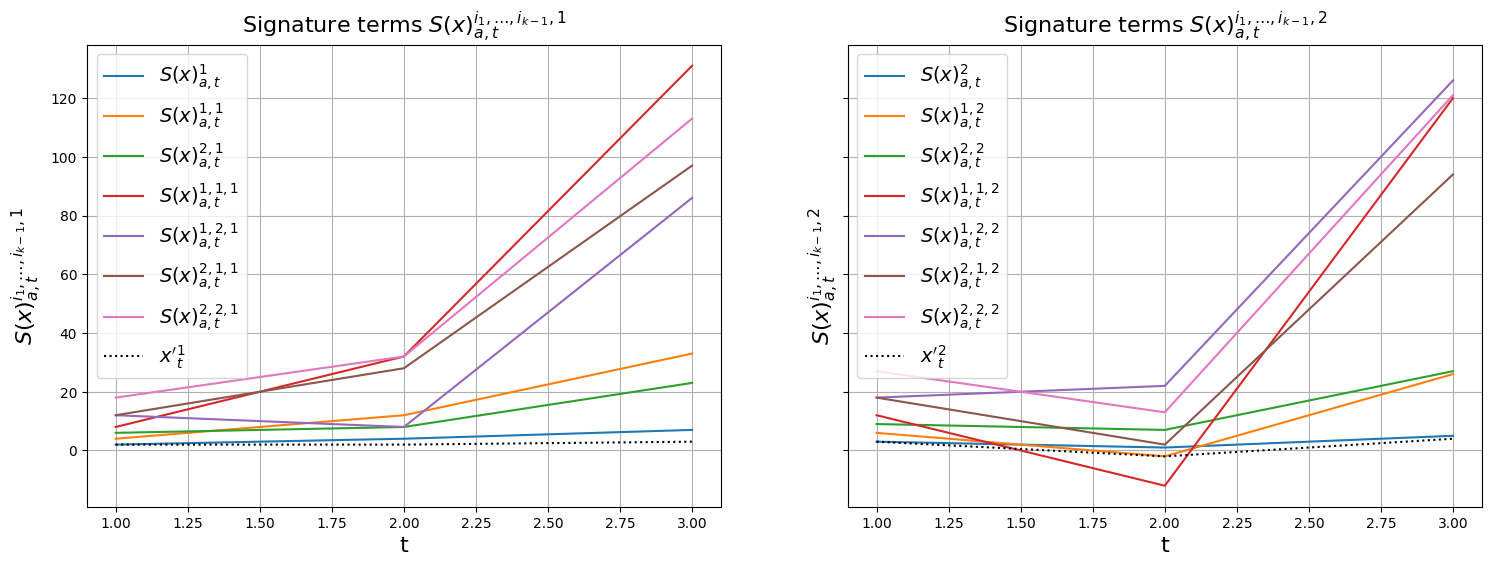

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6),
                        sharex=True, sharey=True)

t, X_t, X_prime_t, signature, signature_terms = compute_seq_signature(x, t, level_threshold=3)
plot_path_signature(t, X_prime_t, signature, signature_terms, '$x_t', axs)

In [11]:
x

array([[1, 3, 5, 8],
       [1, 4, 2, 6]])

In [12]:
signature # answer does not match the example from paper

[[array([1., 1., 1.])],
 [array([2., 4., 7.]), array([3., 1., 5.])],
 [array([ 4., 12., 33.]),
  array([ 6., -2., 26.]),
  array([ 6.,  8., 23.]),
  array([ 9.,  7., 27.])],
 [array([  8.,  32., 131.]),
  array([ 12., -12., 120.]),
  array([12.,  8., 86.]),
  array([ 18.,  22., 126.]),
  array([12., 28., 97.]),
  array([18.,  2., 94.]),
  array([ 18.,  32., 113.]),
  array([ 27.,  13., 121.])]]

### Using iisignature

In [4]:
import iisignature as sig

In [15]:
x = np.array([[1,3,5,8], [1,4,2,6]]).T
t = np.arange(4)
x, x.shape

(array([[1, 1],
        [3, 4],
        [5, 2],
        [8, 6]]),
 (4, 2))

In [16]:
sig.sig(x, 2)

array([ 7. ,  5. , 24.5, 19. , 16. , 12.5])